In [71]:
import torch
from torch.utils.data import DataLoader
from utils import EnhancerDataset, find_tsv_file_path, EnhancerDatasetWithID
from tools import plot_filter_weight,plot_unit_importance
import numpy as np
import numpy
import math
import pandas as pd
import sys
import interpretation
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy
import pandas
import math
from tangermeme.annotate import annotate_seqlets, count_annotations
import torch
from utils import EnhancerDataset, dna_one_hot, split_dataset,EnhancerDatasetWithID
import pickle
from tangermeme.io import read_meme
import gzip

sys.path.append('../../Enhancer')  
from model.model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3

In [2]:
### Define functions for calculating recursive attributions
def _recursive_seqlets_attr(attributions, threshold=0.01, seqlet_len=19, 
	additional_flanks=0):
	"""An internal function implementing the recursive seqlet algorithm."""

	n, l = attributions.shape

	X_cdfs = numpy.zeros(1000, dtype=numpy.float64)

	xmin, xmax = 0.0, 0.0
	n_pos, n_neg = 0.0, 0.0
	for i in range(n):
		for k in range(l):
			x_ = attributions[i, k]
			if x_ > 0:
				xmax = max(x_, xmax)
				n_pos += 1.0
			else:
				xmin = min(x_, xmin)
				n_neg += 1.0
	#print(f'num_pos is {n_pos}, num_neg is {n_neg}')

	p_pos = 1 / n_pos
	if n_neg > 0:
		raise ValueError(f'n_neg is {n_neg}')
	#print(f'p_pos is {p_pos}')

	for i in range(n):
		for k in range(l):
			x_ = attributions[i, k]
			if x_ > 0:
				x_int = math.floor(999 * x_ / xmax)
				X_cdfs[x_int] += p_pos
				#print(f'sample{i}/seqlet{k}: X_cdfs[{x_int}] += {p_pos}')

	#print(f'X_cdfs[0] is {X_cdfs[0]}')
	#print(f'X_cdfs[1] is {X_cdfs[1]}')
	for i in range(1, 1000):
		#print(f'for bin {i}')
		X_cdfs[i] += X_cdfs[i-1]
		#print(f'X_cdfs[{i}] += X_cdfs[{i-1}]')
			
		X_cdfs[i-1] = 1 - X_cdfs[i-1]
		#print(f'X_cdfs[{i-1}] = 1 - X_cdfs[{i-1}]')

		"""X_cdfs is the complement of CDF, which represents the p_value"""
	X_cdfs[-1] = 1 - X_cdfs[-1]
	#print(X_cdfs)
	#print(X_cdfs.shape)
		
    ###
	p_value = numpy.ones(l, dtype=numpy.float64)
	seqlets = []
	for i in range(n):
		#for k in range(1,l):
		for k in range(l):
			#x_ = attributions[i, k-1]
			x_ = attributions[i, k]
			if x_ > 0:
				x_int = math.floor(999 * x_ / xmax)
				p_value[k] = X_cdfs[x_int]
				#print(f'for sample{i}/seqlet{k}, attr is {x_}, p_value: {p_value[k]}')
		
		while True:
			start = p_value.argmin()
			p = p_value[start]
			#print(f'minimum p_value in sample{i} is {p}, with index {start}')
			p_value[start] = 1

			if p > threshold:
				#print(f'start is {start}, > threshold')
				#print('p > threshold, break')
				break
			else:
				#print(f'start is {start}, < threshold')
				#print('p < threshold, continue')
				start = max(start - additional_flanks, 0)
				end = min(start + seqlet_len + additional_flanks, l+seqlet_len-1)
				attr = attributions[i, start]
				seqlets.append((i, start, end, attr, p))
				#print(f'appennd ({i}, {start}, {end}, {attr}, {p})')
	return seqlets

def recursive_seqlets(attributions, threshold=0.01, seqlet_len=19,
	additional_flanks=0):

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.numpy()
    elif not isinstance(attributions, numpy.ndarray):
        raise ValueError("`X` must be either a torch.Tensor or numpy.ndarray.")
    
    columns = ['example_idx', 'start', 'end', 'attribution', 'p-value']
    seqlets = _recursive_seqlets_attr(attributions, threshold, seqlet_len, additional_flanks)
    seqlets = pandas.DataFrame(seqlets, columns = columns)
    return seqlets.sort_values("p-value").reset_index(drop = True)

def p_value(data, values, cdf):
    p_values = []
    for ele in data:
        p_values.append(1 - np.interp(ele, values, cdf))

    return np.array(p_values)

In [4]:
# Define parameters
num_cnns = 75
rep = 8
batch = 168

filter_size = 19
num_class = 2
feature_list = ['G+','G-']
target_labels = ['GFP+','GFP-']
upper_bound = 0.1
result_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/{num_cnns}NN_Rep{rep}'
output_dir = f'/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_{num_cnns}CNN_Rep{rep}'
meme_file = "/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme"
input_data_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv'

In [ ]:
print('--------------------------------------------------------')
print('***********************   1/7   ************************')
print('--------------------------------------------------------')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Attaching device to the {device}')

# Initialize the model without moving it to the device yet
explainn = ExplaiNN3(num_cnns=num_cnns, input_length=608, num_classes=num_class,
                     filter_size=filter_size, num_fc=2, pool_size=7, pool_stride=7,
                     drop_out=0.3, weight_path=None)  # Training

file_list = glob.glob(f'{result_dir}/best_pearson*.pth')
print('Loading weight from following weight file to the model: ')
print(file_list)

if len(file_list) > 0:
    weight_file = file_list[0]
else:
    raise FileExistsError("Best pearson Model file not exist")

print('\n')
# Load the model weights conditionally based on GPU availability
state_dict = torch.load(weight_file, map_location=device)  # Load to the appropriate device

# Check if the state_dict contains keys prefixed with 'module.'
if any(key.startswith('module.') for key in state_dict.keys()):
    # If the state_dict was saved from a DataParallel model, remove the 'module.' prefix
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')  # Remove 'module.' prefix
        new_state_dict[new_key] = value
    state_dict = new_state_dict

# Load the modified state_dict into the model
explainn.load_state_dict(state_dict)

# Move the model to the appropriate device after loading the weights
explainn.to(device)
explainn.eval()
print('\n')

print('--------------------------------------------------------')
print('***********************   2/7   ************************')
print('--------------------------------------------------------')
print('Reading input data for retreiving predictions')
# Load dataset as a pandas dataframe
df = pd.read_csv(input_data_dir)
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ and GFP- as labels
dataset = EnhancerDatasetWithID(df, feature_list=feature_list, scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)
print("Get prediction using trained model!")
print(f'Prediction shape is {predictions.shape}')

--------------------------------------------------------
***********************   1/8   ************************
--------------------------------------------------------
Attaching device to the cpu
Loading weight from following weight file to the model: 
['/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_G+G-_Merged_Pred/75NN_Rep8/best_pearson_model_epoch_85.pth']




--------------------------------------------------------
***********************   2/8   ************************
--------------------------------------------------------
Reading input data for retreiving predictions
Get prediction using trained model!
Prediction shape is (14301, 2)




--------------------------------------------------------
***********************   3/8   ************************
--------------------------------------------------------
Now selecting high confident predictions!
Using Bound = 0.1 as a cutoff to select high confident predictions.
data_ids have length: 14301
Total number of input samples: 14301
Number of input samples with high confident prediction: 3816
Plot histogram of residuals with adjusted cutoff lines
Lower bound: -0.1
Plot for label 0
Plot for label 1


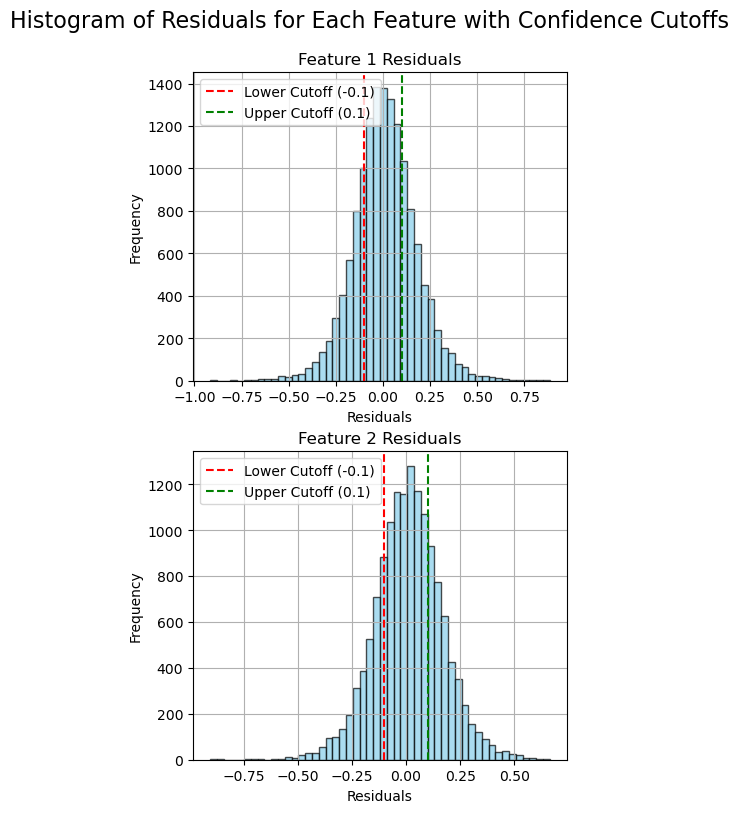

In [ ]:
"""Now filter out low confident predictions"""
print('\n')
print('--------------------------------------------------------')
print('***********************   3/7   ************************')
print('--------------------------------------------------------')

print("Now selecting high confident predictions!")
# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
print(f'Using Bound = {upper_bound} as a cutoff to select high confident predictions.')

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)

# Get sequences and labels from dataset
data_inp = []
data_out = []
data_ids = []
# Iterate over the DataLoader
for batch_features, batch_labels, batch_ids in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
    # Convert tuple of IDs to a NumPy array
    batch_ids_array = np.array(batch_ids)
    data_ids = np.append(data_ids, batch_ids_array)

print(f'data_ids have length: {len(data_ids)}')
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Total number of input samples: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
data_ids = [id_ for id_, m in zip(data_ids, mask) if m]

print(f'Number of input samples with high confident prediction: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
high_conf_dataset = torch.utils.data.TensorDataset(data_inp, data_out)
high_conf_data_loader = torch.utils.data.DataLoader(dataset=high_conf_dataset,
                                          batch_size=batch, shuffle=False,)


print("Plot histogram of residuals with adjusted cutoff lines")
# Plot histogram of residuals with adjusted cutoff lines
# 1. Compute residuals (not absolute)
residuals = labels - predictions

# 2. Define bounds for plotting
lower_bound = -upper_bound
print(f'Lower bound: {lower_bound}')

# 3. Plotting the histograms for each feature
num_labels = predictions.shape[1] if len(predictions.shape) > 1 else 1
fig, axes = plt.subplots(nrows=num_labels, ncols=1, figsize=(5, 4*num_labels))

# Ensure `axes` is iterable (even if it's a single Axes object)
if num_labels == 1:
    axes = [axes]

fig.tight_layout(pad=3.0)

# Title for the entire figure
fig.suptitle('Histogram of Residuals for Each Feature with Confidence Cutoffs', fontsize=16, y=1.02)

for i in range(num_labels):
    print(f'Plot for label {i}')
    ax = axes[i]
    if num_labels > 1:
        residual_col = residuals[:, i]
    else:
        residual_col = residuals

    color = 'skyblue' 
    ax.hist(residual_col, bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(x=lower_bound, color='red', linestyle='--', label=f'Lower Cutoff ({lower_bound})')
    ax.axvline(x=upper_bound, color='green', linestyle='--', label=f'Upper Cutoff ({upper_bound})')
    ax.set_title(f'Feature {i+1} Residuals')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

In [7]:
print('--------------------------------------------------------')
print('***********************   4/7   ************************')
print('--------------------------------------------------------')
print('Calculating activations from each layer of the model if not calculated before!')
# Get weights from activation layer
activation_file_dir = os.path.join(output_dir, 'Model_Activations.npy')
os.makedirs(output_dir, exist_ok=True)

#pwm_file_dir = os.path.join(output_dir, 'Model_PWM.npy')
if os.path.exists(activation_file_dir):
    print(f"Model Activation File Exists. Reading Activation and PWM files.")
    activations = np.load(activation_file_dir)
    print(f"Activations have shape: {activations.shape}")
    #pwms = np.load(pwm_file_dir)
    #print(f"PWMs have shape: {pwms.shape}")
else:
    print(f"Model Activation File NOT Exists. Calculating Activation and PWM files.")
    activations = interpretation.get_explainn_unit_activations(high_conf_data_loader, explainn, device)
    print(f"Activations Calculation Done! Activations have shape: {activations.shape}")
    print('\n')
    # Save activations
    np.save(activation_file_dir, activations)

print('--------------------------------------------------------')
print('***********************   5/7   ************************')
print('--------------------------------------------------------')
print('Get Weight of Each Filter!')
weights = explainn.final.weight.detach().cpu().numpy()
print(f'weight_df has shape: {weights.shape} (number of labels, number of fileters)')
filters = ["f"+str(i) for i in range(num_cnns)]

weight_df = pd.DataFrame(weights, target_labels, columns=filters)
weight_file_dir = os.path.join(output_dir, 'filter_weights.csv')
# Save the DataFrame to a CSV file
weight_df.to_csv(weight_file_dir, index=True)  # Set index=True if you want to save the index

print(f'Weights saved to {weight_file_dir}')
print('\n')

print('--------------------------------------------------------')
print('***********************   6/7   ************************')
print('--------------------------------------------------------')
print('Finding Activated Seqlets for EACH FILTER and Annotate each filter')
# Get torch,  one-hot encoding sequences from data_loader
sequences = []

# Iterate over the DataLoader
for batch in high_conf_data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)
print(f'Sequences used for calculating activations have shape {sequences.shape}')

# activated_indexes would be used to store indexes of activated sequence in each filter
activated_indexes = {}
# motif_count_matrix would store N arrays of motif counts. Each array would have length 234. N is numbe of filters
motif_count_matrix = []
# filter_names_dict would map filter (int) to an array of significant (p_value < 0.01) motif annotations
filter_names_dict = {}

X = sequences
motifs = read_meme(meme_file)
motif_names = np.array(list(motifs.keys()))
motif_names = [name.split(" ", 1)[1] if " " in name else name for name in motif_names]
motif_names = np.array(motif_names)
#motif_names = [name.split(" ", 1)[1].rsplit(".", 1)[-1] for name in motif_names]

for f in tqdm(range(num_cnns), desc="Annotating Filters"):
    print(f"Annotating Filter {f}")
    seqlets = recursive_seqlets(activations[:,f,:], seqlet_len=19, threshold=0.01)
    # Get indexes of sequences contain at least one significant seqlet for importance score calculation
    activated_sample_ids = np.array(seqlets['example_idx'])
    activated_sample_ids = np.unique(activated_sample_ids)
    activated_indexes[f] = (list(activated_sample_ids))

    # Annotate each seqlet by the most likely motif id
    motif_idxs = annotate_seqlets(X, seqlets, meme_file)[0][:, 0]
    # Count number of seqlets in each sample
    y = count_annotations((seqlets['example_idx'], motif_idxs),shape = (X.shape[0],224))
    y_sum = y.sum(dim=0)
    motif_count_matrix.append(np.array(y_sum))

    # Calculate the CDF
    values, counts = np.unique(y_sum, return_counts=True)
    cdf = np.cumsum(counts) / len(y_sum)
    p_values = p_value(y_sum, values, cdf)
    sig_index = np.where(p_values <= 0.01)[0]
    if sig_index.size == 0:
        filter_names = []
        filter_names_dict[f] = filter_names
    else:
        #print("Original sig_index:", sig_index)
        sig_p_values = p_values[sig_index]
        #print("Corresponding p-values:", sig_p_values)
        sorted_order = np.argsort(sig_p_values)
        #print("Sorting order:", sorted_order)
        sorted_sig_index = sig_index[sorted_order]
        #print("Sorted sig_index:", sorted_sig_index)

        names = motif_names[sorted_sig_index]
        print(f'Filter {f} can be annotated as {names}')
        filter_names_dict[f] = names

### Save filter motif count matrix into a pandas data frame and a csv file
filter_numbers = range(len(motif_count_matrix))  # Filter numbers as a column

# Convert motif_count_matrix to a DataFrame
filter_motif_count_df = pd.DataFrame(
    data=motif_count_matrix,  # Rows
    columns=motif_names  # Columns
)

# Add Filter_Number as a column
filter_motif_count_df["Filter_Number"] = filter_numbers
filter_motif_count_file_dir = os.path.join(output_dir, 'filter_motif_counts.csv')
filter_motif_count_df.to_csv(filter_motif_count_file_dir)

### Save filter to motif name dictionary to a pickle file
filter2motif_dict_dir = os.path.join(output_dir, 'filter2motif_dictionary.pkl')
# Save the dictionary to a pickle file
with open(filter2motif_dict_dir, "wb") as pickle_file:
    pickle.dump(filter_names_dict, pickle_file)





--------------------------------------------------------
***********************   4/8   ************************
--------------------------------------------------------
Calculating activations from each layer of the model if not calculated before!
Model Activation File NOT Exists. Calculating Activation and PWM files.


100%|████████████████████| 23/23 [00:09<00:00,  2.46it/s]


Activations Calculation Done! Activations have shape: (3816, 75, 590)


--------------------------------------------------------
***********************   5/8   ************************
--------------------------------------------------------
Finding Activated Seqlets for EACH FILTER and Annotate each filter
Sequences used for calculating activations have shape torch.Size([3816, 4, 608])


Annotating Filters:   0%|          | 0/1 [00:00<?, ?it/s]

Annotating Filter 0


Annotating Filters: 100%|██████████| 1/1 [02:37<00:00, 157.05s/it]

Filter 0 can be annotated as ['MA0078.1.Sox17' 'MA0124.2.Nkx3-1' 'MA0734.3.Gli2']


In [16]:
print('--------------------------------------------------------')
print('***********************   7/7   ************************')
print('--------------------------------------------------------')
print('Calculating Unit Importance For Each Label')
importance_result_dir = os.path.join(output_dir, 'importance')
os.makedirs(importance_result_dir, exist_ok=True)
importance_dictionary_file = os.path.join(importance_result_dir, 'importance_dict.pkl')

# Check if the file exists
if os.path.exists(importance_dictionary_file):
    with open(importance_dictionary_file, 'rb') as f:
        importance_dict = pickle.load(f)
    print(f"Importance dictionary already exists. Loaded the importance dictionary from {importance_dictionary_file}.")
else:
    importance_dict = {}
    for label in target_labels:
        importance_dict[label] = []
    # Use tqdm to track progress over the loop
    unit_outputs = interpretation.get_explainn_unit_outputs(high_conf_data_loader, explainn, device)
    for unit_index in tqdm(range(num_cnns), desc="Processing units"):
        # Calculate unit importance for the current unit
        importance = interpretation.get_specific_unit_importance_seqlet(activated_indexes, explainn, unit_outputs, unit_index, target_labels)

        # Store the importance for each label
        for label in target_labels:
            importance_dict[label].append(importance[label])

    with open(importance_dictionary_file, 'wb') as f:
        pickle.dump(importance_dict, f)

print(f'Importance dictionary saved to {importance_dictionary_file}')
print('\n')
print('Plotting Unit Importance Plot')
unit_names = list(weight_df.columns)
for label in target_labels:
    #_, _, _ = plot_unit_importance(importance_dict[label], unit_names, label, dir_save_plot = importance_result_dir, annotated_filter_only=True, num_tf_plotted=10)
    sorted_filters, sorted_values, sorted_unit_samples = plot_unit_importance(importance_dict[label], unit_names, label, dir_save_plot = importance_result_dir, annotated_filter_only=False, num_tf_plotted=False)
    # Save sorted_names to a plain text file
    #sorted_tf_order_file = os.path.join(importance_result_dir, f'{label}_sorted_tf_order.txt')
    #with open(sorted_tf_order_file, 'w') as f:
    #    for name in sorted_filters:
    #        f.write(f"{name}\n")

    # Save sorted_filters and sorted_values to a CSV file
    sorted_tf_order_file = os.path.join(importance_result_dir, f'{label}_sorted_tf_order.csv')
    sorted_df = pd.DataFrame({'tf_name': sorted_filters, 'importance_score': sorted_values,'activated_samples': sorted_unit_samples})
    sorted_df.to_csv(sorted_tf_order_file, index=False)

print('Finish!')

--------------------------------------------------------
***********************   7/8   ************************
--------------------------------------------------------
Get Weight of Each Filter!
weight_df has shape: (2, 20) (number of labels, number of fileters)
Weights saved to /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/filter_weights.csv


--------------------------------------------------------
***********************   8/8   ************************
--------------------------------------------------------
Calculating Unit Importance For Each Label


Processing units: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Importance dictionary saved to /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/importance/importance_dict.pkl


Plotting Unit Importance Plot
Saved unit importance plot for GFP+ at /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/importance/top10_annotated_filter_unit_importance_GFP+.png
Saved unit importance plot for GFP+ at /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/importance/filter_unit_importance_GFP+.png
Saved unit importance plot for GFP- at /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/importance/top10_annotated_filter_unit_importance_GFP-.png
Saved unit importance plot for GFP- at /pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN_Rep1/importance/filter_unit_importance_GFP-.png
Finish!


In [27]:
a = importance_dict['GFP+']
a[4].shape

(60,)

# Test Recursive_Seqlets

In [4]:
import numpy
import torch
import pandas
import math
def _recursive_seqlets(X, threshold=0.01, min_seqlet_len=4, max_seqlet_len=25, 
	additional_flanks=0):
	"""An internal function implementing the recursive seqlet algorithm."""

	n, l = X.shape

	X_csum = numpy.empty_like(X)
	for i in range(n):
		X_csum[i, 0] = X[i, 0]    
		for j in range(1, l):
			X_csum[i, j] = X_csum[i, j-1] + X[i, j]

	print(f'X_cscum has shape: {X_csum.shape}')
	print('X_cscum is:')
	print(X_csum)

	xmins = numpy.empty(max_seqlet_len+1, dtype=numpy.float64)
	xmaxs = numpy.empty(max_seqlet_len+1, dtype=numpy.float64)
	X_cdfs = numpy.zeros((2, max_seqlet_len+1, 1000), dtype=numpy.float64)

	for j in range(min_seqlet_len, max_seqlet_len+1):
		print(f'for seqlet length {j}')
		xmin, xmax = 0.0, 0.0
		n_pos, n_neg = 0.0, 0.0
		
		for i in range(n):
			print(f'for sample {i}')
			for k in range(l-j):
				x_ = X_csum[i, k+j] - X_csum[i, k]
				print(f'seqlet {k} ({k+j}-{k}) has attribution: {x_}')

				if x_ > 0:
					xmax = max(x_, xmax)
					n_pos += 1.0
				else:
					xmin = min(x_, xmin)
					n_neg += 1.0
		
		xmins[j] = xmin
		xmaxs[j] = xmax
		print(f'num_pos is {n_pos}, num_neg is {n_neg}')

		p_pos, p_neg = 1 / n_pos, 1 / n_neg
		print(f'p_pos is {p_pos}, p_neg is {p_pos}')

		for i in range(n):
			for k in range(l-j):
				x_ = X_csum[i, k+j] - X_csum[i, k]

				if x_ > 0:
					x_int = math.floor(999 * x_ / xmax)
					X_cdfs[0, j, x_int] += p_pos
				else:
					x_int = math.floor(999 * x_ / xmin)
					X_cdfs[1, j, x_int] += p_neg
					

		for i in range(1, 1000):
			X_cdfs[0, j, i] += X_cdfs[0, j, i-1]
			X_cdfs[1, j, i] += X_cdfs[1, j, i-1]
			
			X_cdfs[0, j, i-1] = 1 - X_cdfs[0, j, i-1]
			X_cdfs[1, j, i-1] = 1 - X_cdfs[1, j, i-1]
		
		X_cdfs[0, j, -1] = 1 - X_cdfs[0, j, -1]
		X_cdfs[1, j, -1] = 1 - X_cdfs[1, j, -1]
	
	###

	p_value = numpy.ones((max_seqlet_len+1, l), dtype=numpy.float64)
	seqlets = []
	for i in range(n):
		for j in range(min_seqlet_len, max_seqlet_len+1):
			for k in range(1, l-j):
				x_ = X_csum[i, k+j-1] - X_csum[i, k-1]

				if x_ > 0:
					x_int = math.floor(999 * x_ / xmaxs[j])
					p_value[j, k] = X_cdfs[0, j, x_int]
				else:
					x_int = math.floor(999 * x_ / xmins[j])
					p_value[j, k] = X_cdfs[1, j, x_int]
				
				if j > min_seqlet_len:
					p_value[j, k] = max(p_value[j-1, k], p_value[j, k])

		###
			
		for j in range(max_seqlet_len - min_seqlet_len):
			j = max_seqlet_len - j
			
			while True:
				start = p_value[j].argmin()
				p = p_value[j, start]
				p_value[j, start] = 1
	
				if p > threshold:
					break
	
				end = start
				for k in range(j - min_seqlet_len):
					if p_value[j-k, end+1] < threshold:
						end += 1
					else:
						break
				else:
					start = max(start - additional_flanks, 0)
					end = min(end + min_seqlet_len + additional_flanks - 1, l)
					attr = X_csum[i, end-1] - X_csum[i, start-1]
					seqlets.append((i, start, end, attr, p))

					for n_idx in range(max_seqlet_len+1):
						for s_idx in range(start, end):
							p_value[n_idx, s_idx] = 1

	return seqlets


# Recursive_Attribution

In [71]:
import numpy
import pandas
import math
from tangermeme.annotate import annotate_seqlets, count_annotations
import torch
from utils import EnhancerDataset, dna_one_hot, split_dataset,EnhancerDatasetWithID
import pickle
from tangermeme.io import read_meme
import gzip


def _recursive_seqlets_attr(attributions, threshold=0.01, seqlet_len=19, 
	additional_flanks=0):
	"""An internal function implementing the recursive seqlet algorithm."""

	n, l = attributions.shape

	X_cdfs = numpy.zeros(1000, dtype=numpy.float64)

	xmin, xmax = 0.0, 0.0
	n_pos, n_neg = 0.0, 0.0
	for i in range(n):
		for k in range(l):
			x_ = attributions[i, k]
			if x_ > 0:
				xmax = max(x_, xmax)
				n_pos += 1.0
			else:
				xmin = min(x_, xmin)
				n_neg += 1.0
	#print(f'num_pos is {n_pos}, num_neg is {n_neg}')

	p_pos = 1 / n_pos
	if n_neg > 0:
		raise ValueError(f'n_neg is {n_neg}')
	#print(f'p_pos is {p_pos}')

	for i in range(n):
		for k in range(l):
			x_ = attributions[i, k]
			if x_ > 0:
				x_int = math.floor(999 * x_ / xmax)
				X_cdfs[x_int] += p_pos
				#print(f'sample{i}/seqlet{k}: X_cdfs[{x_int}] += {p_pos}')

	#print(f'X_cdfs[0] is {X_cdfs[0]}')
	#print(f'X_cdfs[1] is {X_cdfs[1]}')
	for i in range(1, 1000):
		#print(f'for bin {i}')
		X_cdfs[i] += X_cdfs[i-1]
		#print(f'X_cdfs[{i}] += X_cdfs[{i-1}]')
			
		X_cdfs[i-1] = 1 - X_cdfs[i-1]
		#print(f'X_cdfs[{i-1}] = 1 - X_cdfs[{i-1}]')

		"""X_cdfs is the complement of CDF, which represents the p_value"""
	X_cdfs[-1] = 1 - X_cdfs[-1]
	#print(X_cdfs)
	#print(X_cdfs.shape)
		
    ###
	p_value = numpy.ones(l, dtype=numpy.float64)
	seqlets = []
	for i in range(n):
		#for k in range(1,l):
		for k in range(l):
			#x_ = attributions[i, k-1]
			x_ = attributions[i, k]
			if x_ > 0:
				x_int = math.floor(999 * x_ / xmax)
				p_value[k] = X_cdfs[x_int]
				#print(f'for sample{i}/seqlet{k}, attr is {x_}, p_value: {p_value[k]}')
		
		while True:
			start = p_value.argmin()
			p = p_value[start]
			#print(f'minimum p_value in sample{i} is {p}, with index {start}')
			p_value[start] = 1

			if p > threshold:
				#print(f'start is {start}, > threshold')
				#print('p > threshold, break')
				break
			else:
				#print(f'start is {start}, < threshold')
				#print('p < threshold, continue')
				start = max(start - additional_flanks, 0)
				end = min(start + seqlet_len + additional_flanks, l+seqlet_len-1)
				attr = attributions[i, start]
				seqlets.append((i, start, end, attr, p))
				#print(f'appennd ({i}, {start}, {end}, {attr}, {p})')
	return seqlets

def recursive_seqlets(attributions, threshold=0.01, seqlet_len=19,
	additional_flanks=0):

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.numpy()
    elif not isinstance(attributions, numpy.ndarray):
        raise ValueError("`X` must be either a torch.Tensor or numpy.ndarray.")
    
    columns = ['example_idx', 'start', 'end', 'attribution', 'p-value']
    seqlets = _recursive_seqlets_attr(attributions, threshold, seqlet_len, additional_flanks)
    seqlets = pandas.DataFrame(seqlets, columns = columns)
    return seqlets.sort_values("p-value").reset_index(drop = True)

In [7]:
test_attr = numpy.array([
    [0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.99],
    [0.001,0.001,0.98,0.001,0.001,0.001,0.001,0.002],
    [0.001,0.99,0.001,0.001,0.001,0.001,0.001,0.002],
    [0.91,0.001,0.001,0.001,0.001,0.001,0.001,0.002],
])

test_result = recursive_seqlets(test_attr, seqlet_len=4, threshold = 0.05)
test_result

,example_idx,start,end,attribution,p-value
0,0,7,11,0.99,0.0
1,2,1,5,0.99,0.0


In [ ]:
# File path
file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/Activations/ExplaiNN_20CNN/test_activations.pkl.gz'

# Open and load the compressed pickle file
with gzip.open(file_path, 'rb') as f:
    data = pickle.load(f)

# Now `data` contains the loaded object
print(data.shape)
test_data = data[:,0,:]

#test_data = data[:3,0,:3]
print(test_data.shape)
print(test_data)



(438, 20, 590)
(438, 590)
[[2.02   1.015  2.324  ... 3.195  0.2502 1.452 ]
 [1.419  0.7456 0.6504 ... 1.096  0.5967 0.8013]
 [1.085  0.5864 1.022  ... 0.8467 0.8423 0.8735]
 ...
 [1.124  3.387  3.719  ... 1.463  0.404  0.3367]
 [2.02   1.015  2.324  ... 0.386  0.2944 0.4155]
 [1.105  0.2573 0.706  ... 3.797  0.9863 3.098 ]]


In [11]:
seqlets = recursive_seqlets(test_data, threshold=0.01)
seqlets

,example_idx,start,end,attribution,p-value
0,58,173,192,47.687500,6.328271e-15
1,305,581,600,47.687500,6.328271e-15
2,395,581,600,47.687500,6.328271e-15
3,426,581,600,47.687500,6.328271e-15
4,231,481,500,47.687500,6.328271e-15
...,...,...,...,...,...
2684,143,66,85,8.632812,9.964399e-03
2685,38,66,85,8.632812,9.964399e-03
2686,412,270,289,8.632812,9.964399e-03
2687,19,574,593,8.632812,9.964399e-03


In [13]:
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/filtered_merged_data.csv')

# Assuming 'sequence' column contains DNA sequences
sequences = df['sequence'].values  # Extract sequences as a NumPy array

# Convert sequences to one-hot encodings
one_hot_encodings = [dna_one_hot(seq) for seq in sequences]

# Stack the one-hot encoded arrays along the first dimension
X = np.stack(one_hot_encodings, axis=0)  # Shape: [n_samples, 4, dna_length]

# Convert to a PyTorch tensor
X = torch.tensor(X, dtype=torch.float32)  # Shape: [n_samples, 4, dna_length]
print(X.shape)

meme_file = "/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_with_id.meme"
motifs = read_meme(meme_file)

motif_idxs = annotate_seqlets(X, seqlets, meme_file)[0][:, 0]

torch.Size([14301, 4, 608])


In [ ]:
y = count_annotations((seqlets['example_idx'], motif_idxs))
print(y.shape)
motif_names = np.array(list(motifs.keys()))

y_sum = y.sum(dim=0)
idxs = torch.flip(torch.argsort(y_sum), dims=(-1,))